In [1]:
### test_lgs_params.ipynb
### attempting to pull relevant parameters from science and weather data
### imports
import numpy as np
import pandas as pd
import glob
from astropy.table import Table
from astropy.io import fits
import lgs_metadata_compiler as md
import matplotlib.pyplot as plt
### My file
import ML_util as util
### ML algorithms
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
### Files and folders
root_dir = "/g/lu/data/gc" # root data directory
tables = "LGS_AO_data/steve_metadata/" # folder of data tables found in Steve's directory
meta_file = tables+"lgs_metadata2.fits" # test metadata table
# strehl and fwhm are labels, the rest are features
use_cols = ['strehl', 'fwhm', 'airmass', 'az', 'MASS', 'DIMM', 'wind_speed', 
               'wind_direction', 'temperature', 'relative_humidity', 'pressure']
Y_data = use_cols[:2]
# guessing that DIMM is the DIMM seeing, MASS is the MASS seeing
# not really sure what units anything is in

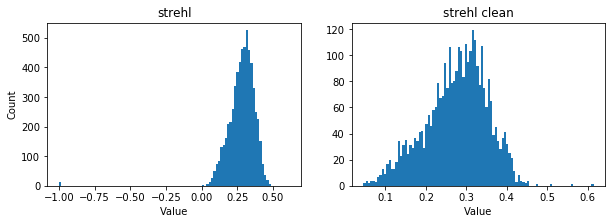

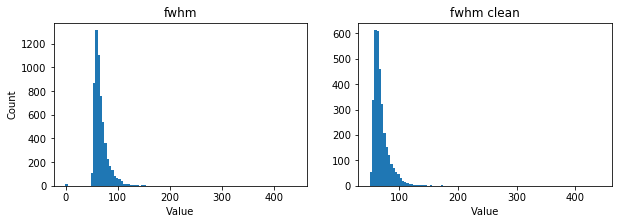

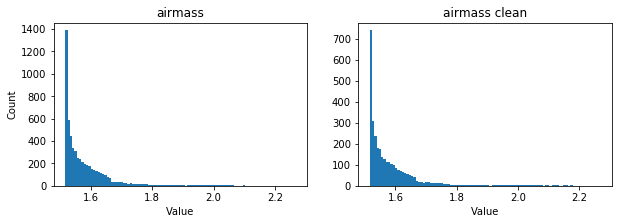

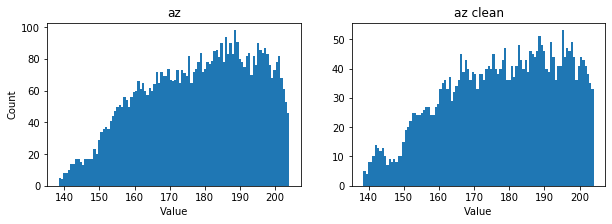

/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


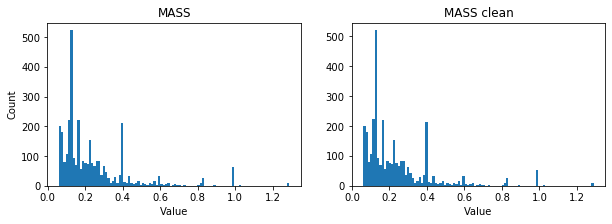

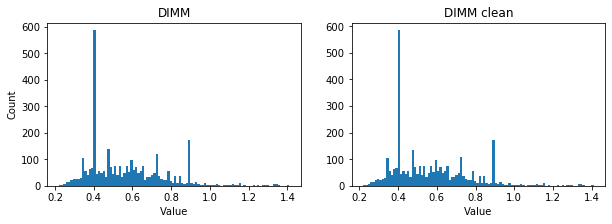

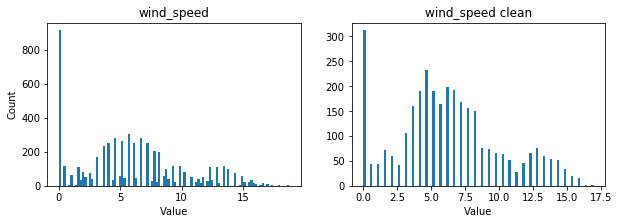

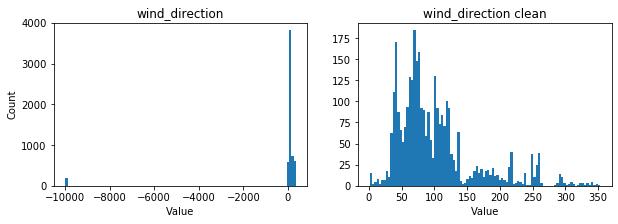

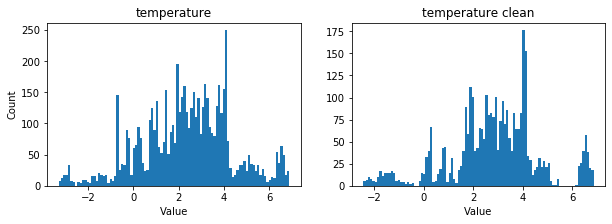

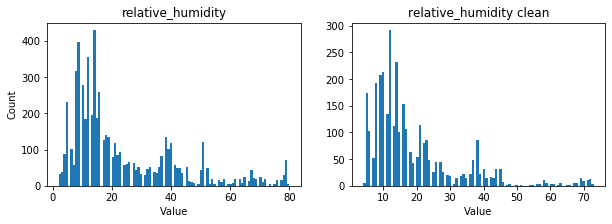

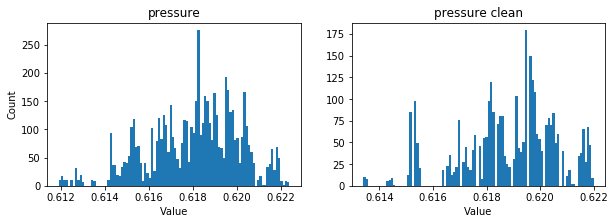

In [3]:
### Read info from Steve's metadata files
meta_data = Table.read(meta_file)
meta_data = meta_data.to_pandas() # convert to pandas

# extract relevant data
meta_data = meta_data[use_cols]
# clean data
meta_clean = util.clean(meta_data)

### Graph the features to see what values they take on
bins = 100
for col in use_cols:
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax[0].hist(meta_data[col], bins)
    ax[0].set_title(col)
    ax[0].set_xlabel("Value")
    ax[0].set_ylabel("Count")
    
    ax[1].hist(meta_clean[col], bins)
    ax[1].set_xlabel("Value")
    ax[1].set_title(col+" clean")
    
    plt.show()

In [6]:
# Extract y variables
Y = meta_clean[use_cols[:2]]
strehl = meta_clean['strehl']
fwhm = meta_clean['fwhm']

# Extract x variables
X = meta_clean[use_columns[2:]]

In [7]:
### Scale the data
# StandardScaler() subtracts the mean and divides by the standard deviation
# Very important for PCA to normalize for high-magnitude features
X_scaled = StandardScaler().fit_transform(X)
# (1-tolerance) is the amount (%) of variation we keep in our data
tolerance = 0.01

In [8]:
### Basic PCA - extracts features which have the most variation in the data
pca = PCA(1-tolerance)
pca.fit(X_scaled)
# View variance ratios
list(np.round(pca.explained_variance_ratio_, 2))
# 1. If the emphasis is on knowing what our features mean then this is not a great algorithm to use
# 2. We have so few features that we probably don't need to eliminate any if we use them as-is
# 3. The explained variance ratios are also all fairly small, so PCA isn't likely to help a lot

[0.25, 0.21, 0.17, 0.12, 0.08, 0.07, 0.05, 0.04, 0.01]

In [9]:
### Testing Random Forest Regressor
# This does not rely on feature scale, so we will leave it out
# This is basically identical to Kaggle's Intro ML exercise - just a proof of concept
rand_state = np.random.randint(100000)
percent_errors = {}
for col in Y.columns:
    y = Y[col] # extract one label column
    rf = RandomForestRegressor(random_state=rand_state) # set up regressor
    # train-test split
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=rand_state)
    rf.fit(train_X, train_y) # fit model
    # get predictions
    rf_predictions = rf.predict(val_X)
    percent_errors[col] = (rf_predictions-val_y)/val_y
    rf_mape = np.mean(np.abs(percent_errors[col]))
    # display results as mean absolute percentage error
    print("Mean Absolute Percentage Error for", col, ":", rf_mape*100,"%")

/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Mean Absolute Percentage Error for strehl : 12.925744020806476 %
Mean Absolute Percentage Error for fwhm : 6.708759002298639 %


In [10]:
### Question: what does a fwhm value of -1 mean? This doesn't seem like a valid number,
### so I have excluded it in the clean data
### could do k-fold cross-validation instead of just one test set, but I want to make sure
### that I remember it correctly first and that I know how to use it in sklearn
### * also, it takes a really long time and we're already doing grid search :/

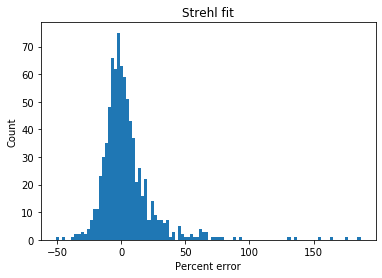

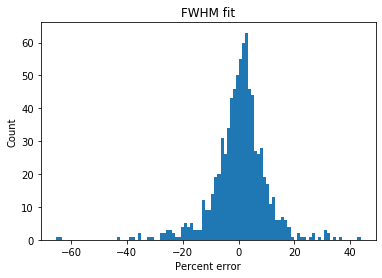

In [13]:
### Plots
# Strehl
plt.hist(100*percent_errors['strehl'], bins=100)
plt.title("Strehl fit")
plt.xlabel("Percent error")
plt.ylabel("Count")
plt.savefig("strehl_naive_rf_err.png")
plt.show()

# FWHM
plt.hist(100*percent_errors['fwhm'], bins=100)
plt.title("FWHM fit")
plt.xlabel("Percent error")
plt.ylabel("Count")
plt.savefig("fwhm_naive_rf_err.png")
plt.show()